In [1]:
import os
import sys
import argparse
from tqdm import tqdm
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import numpy as np
import pandas as pd
from datetime import timedelta
import time
import seaborn as sns
from utils import visualization as viz
from utils import data
import gdal
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc, roc_auc_score, jaccard_score
from xgboost import plot_importance
from joblib import dump, load
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20
from feature_selection import fselector
from sklearn.model_selection import train_test_split

In [2]:
new_y_pred = np.load('../sensing_data/models/new_tune_y_pred.npy')
new_y_true = np.load('../sensing_data/models/new_tune_y_true.npy')

In [3]:
old_y_pred = np.load('../sensing_data/models/og_tune_y_pred.npy')
old_y_true = np.load('../sensing_data/models/og_tune_y_true.npy')

In [4]:
# Check for integrity

In [5]:
(new_y_true == old_y_true).all()

True

In [6]:
def plot_calssification_report(report):
    df = pd.DataFrame(report).T

    df['support'] = df.support.apply(int)

    df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'1', :'f1-score'])

In [7]:
def compute_roc(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_score)
    return fpr, tpr, thresholds, roc_auc

In [8]:
def plo_roc(fpr, tpr, opt_t_idx, roc_auc):
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', label='Classifier')
    plt.plot(fpr[opt_t_idx], tpr[opt_t_idx], marker='*', label='Best T')
    plt.plot([0,1], [0,1], marker='.', label='X=Y')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [9]:
def scores(y_test, y_pred, verbose=1):
    kappa = cohen_kappa_score(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=2)
    roc_auc = roc_auc_score(y_test, y_pred)
    j_score = jaccard_score(y_test, y_pred)
    if verbose:
        print(f'Kappa: {kappa}')
        print(report)
        sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
        print('Roc Auc: ', roc_auc)
        print('Jaccard Score: ', j_score)
    return kappa, cf_matrix, report, roc_auc

In [10]:
def compare_metrics(classi_a, classi_b):
    fpr, tpr, thresholds, roc_auc = compute_roc(classi_a, classi_b)
    kappa, matrix, report, roc_auc = scores(classi_a, classi_b, verbose=1)

In [11]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

#  Original tune vs GT

Kappa: 0.7328374109191138
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    741525
           1       0.82      0.68      0.74     33940

    accuracy                           0.98    775465
   macro avg       0.90      0.84      0.87    775465
weighted avg       0.98      0.98      0.98    775465

Roc Auc:  0.8358168207243521
Jaccard Score:  0.5916075650118203


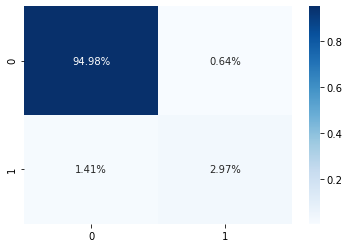

In [12]:
compare_metrics(old_y_true, old_y_pred)

#  Cluster tune vs GT

Kappa: 0.7657261929251125
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    741525
           1       0.85      0.72      0.78     33940

    accuracy                           0.98    775465
   macro avg       0.92      0.85      0.88    775465
weighted avg       0.98      0.98      0.98    775465

Roc Auc:  0.8546768614989929
Jaccard Score:  0.6328163690864069


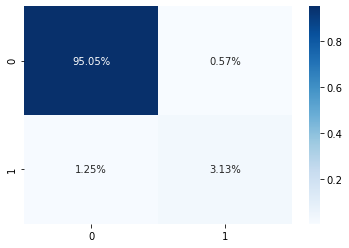

In [13]:
compare_metrics(new_y_true, new_y_pred)

#  New tune vs Old tune (A vs B)

Kappa: 0.8875328693216071
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    746762
           1       0.90      0.88      0.89     28703

    accuracy                           0.99    775465
   macro avg       0.95      0.94      0.94    775465
weighted avg       0.99      0.99      0.99    775465

Roc Auc:  0.9385334707158526
Jaccard Score:  0.8044744295579671


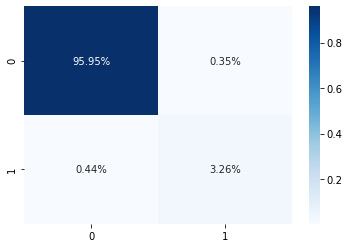

In [14]:
compare_metrics(new_y_pred, old_y_pred)

Kappa: 0.8875328693216071
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    747466
           1       0.88      0.90      0.89     27999

    accuracy                           0.99    775465
   macro avg       0.94      0.95      0.94    775465
weighted avg       0.99      0.99      0.99    775465

Roc Auc:  0.949136431490429
Jaccard Score:  0.8044744295579671


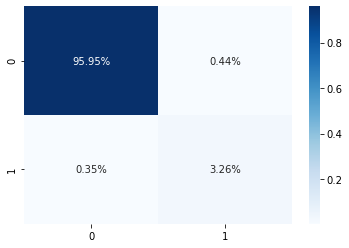

In [15]:
compare_metrics(old_y_pred, new_y_pred)

#  Building merge classifiers

In [16]:
disjoint_classifier = (old_y_pred & (1 - new_y_pred)) | ((1 - old_y_pred) & new_y_pred)

In [17]:
joint_classifier = old_y_pred & new_y_pred

In [18]:
union_classifier = old_y_pred | new_y_pred

In [19]:
inside_gt_classifier_b = (old_y_pred & (old_y_true)) 
inside_gt_classifier_a = (new_y_pred & (new_y_true))

outside_gt_classifier_b = (old_y_pred & (1 - old_y_true)) 
outside_gt_classifier_a = (new_y_pred & (1 - new_y_true))

#  Disjoint vs GT

Kappa: 0.15465934749958044
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    741525
           1       0.54      0.10      0.17     33940

    accuracy                           0.96    775465
   macro avg       0.75      0.55      0.57    775465
weighted avg       0.94      0.96      0.94    775465

Roc Auc:  0.5471135001116625
Jaccard Score:  0.09051337160268792


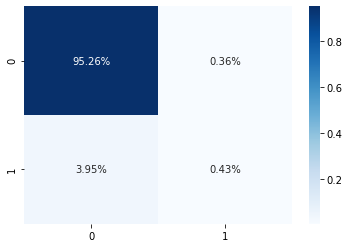

In [20]:
compare_metrics(new_y_true, disjoint_classifier)

#  Joint vs GT

Kappa: 0.7325730113142299
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    741525
           1       0.87      0.65      0.74     33940

    accuracy                           0.98    775465
   macro avg       0.93      0.82      0.87    775465
weighted avg       0.98      0.98      0.98    775465

Roc Auc:  0.8216900910558412
Jaccard Score:  0.5905403953588311


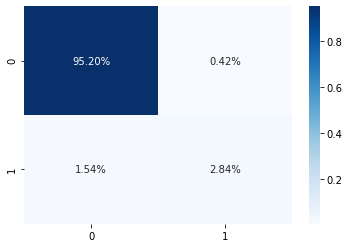

In [21]:
compare_metrics(new_y_true, joint_classifier)

#  Union vs GT

Kappa: 0.7646632334720334
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    741525
           1       0.81      0.75      0.77     33940

    accuracy                           0.98    775465
   macro avg       0.90      0.87      0.88    775465
weighted avg       0.98      0.98      0.98    775465

Roc Auc:  0.8688035911675037
Jaccard Score:  0.6320757072586082


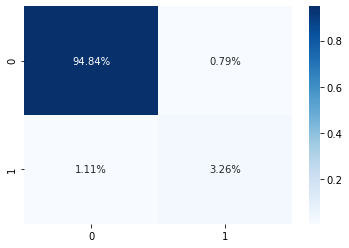

In [22]:
compare_metrics(new_y_true, union_classifier)

#  Behaviour outside of GT

Kappa: 0.6985299357629786
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    770489
           1       0.74      0.66      0.70      4976

    accuracy                           1.00    775465
   macro avg       0.87      0.83      0.85    775465
weighted avg       1.00      1.00      1.00    775465

Roc Auc:  0.8300525339945822
Jaccard Score:  0.5388770666230153


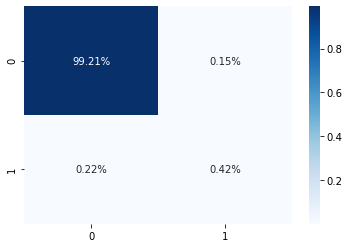

In [23]:
compare_metrics(outside_gt_classifier_b, outside_gt_classifier_a)

Kappa: 0.9274521803552987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    752442
           1       0.91      0.96      0.93     23023

    accuracy                           1.00    775465
   macro avg       0.95      0.98      0.96    775465
weighted avg       1.00      1.00      1.00    775465

Roc Auc:  0.9759783836339267
Jaccard Score:  0.8685707513628822


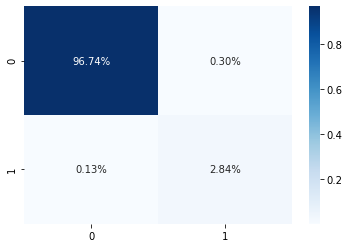

In [24]:
compare_metrics(inside_gt_classifier_b, inside_gt_classifier_a)

#  ROC classification test

In [15]:
raster_ds = gdal.Open('../sensing_data/clipped/vila-de-rei/tstats/ndvi_q4.tiff', gdal.GA_ReadOnly)
test_ds = raster_ds.GetRasterBand(1).ReadAsArray()
print(np.max(test_ds))
print(np.min(test_ds))
test_ds = (test_ds - np.min(test_ds))/(np.max(test_ds) - np.min(test_ds))

test_ds_true = gdal.Open('../sensing_data/clipped/vila-de-rei/cos_new_gt_2015t.tiff', gdal.GA_ReadOnly)
test_ds_true = test_ds_true.GetRasterBand(1).ReadAsArray()

0.9997046
-0.20758331


In [16]:
max = np.max(test_ds)
min = np.min(test_ds)
t = 0.3942345380783081

In [17]:
print(np.max(test_ds))
print(np.min(test_ds))

print(np.max(test_ds))
print(np.min(test_ds))

print(np.max(test_ds_true))
print(np.min(test_ds_true))
print(np.median(test_ds_true))

unique, counts = np.unique(test_ds_true, return_counts=True)
dict(zip(unique, counts))

1.0
0.0
1.0
0.0
1
0
0.0


{0: 18538114, 1: 848511}

In [18]:
src_dss = [ f for f in os.listdir('../sensing_data/clipped/vila-de-rei/tstats') if ("ndvi" in f)]
src_dss

['ndvi_mean.tiff',
 'ndvi_q0.tiff',
 'ndvi_q1.tiff',
 'ndvi_q2.tiff',
 'ndvi_q3.tiff',
 'ndvi_q4.tiff',
 'ndvi_var.tiff']

ndvi_mean.tiff
[2.         1.         0.8637164  ... 0.02273035 0.0226931  0.        ]
best T:  [0.36036157608032227]
ROC AUC:  0.838322955196219


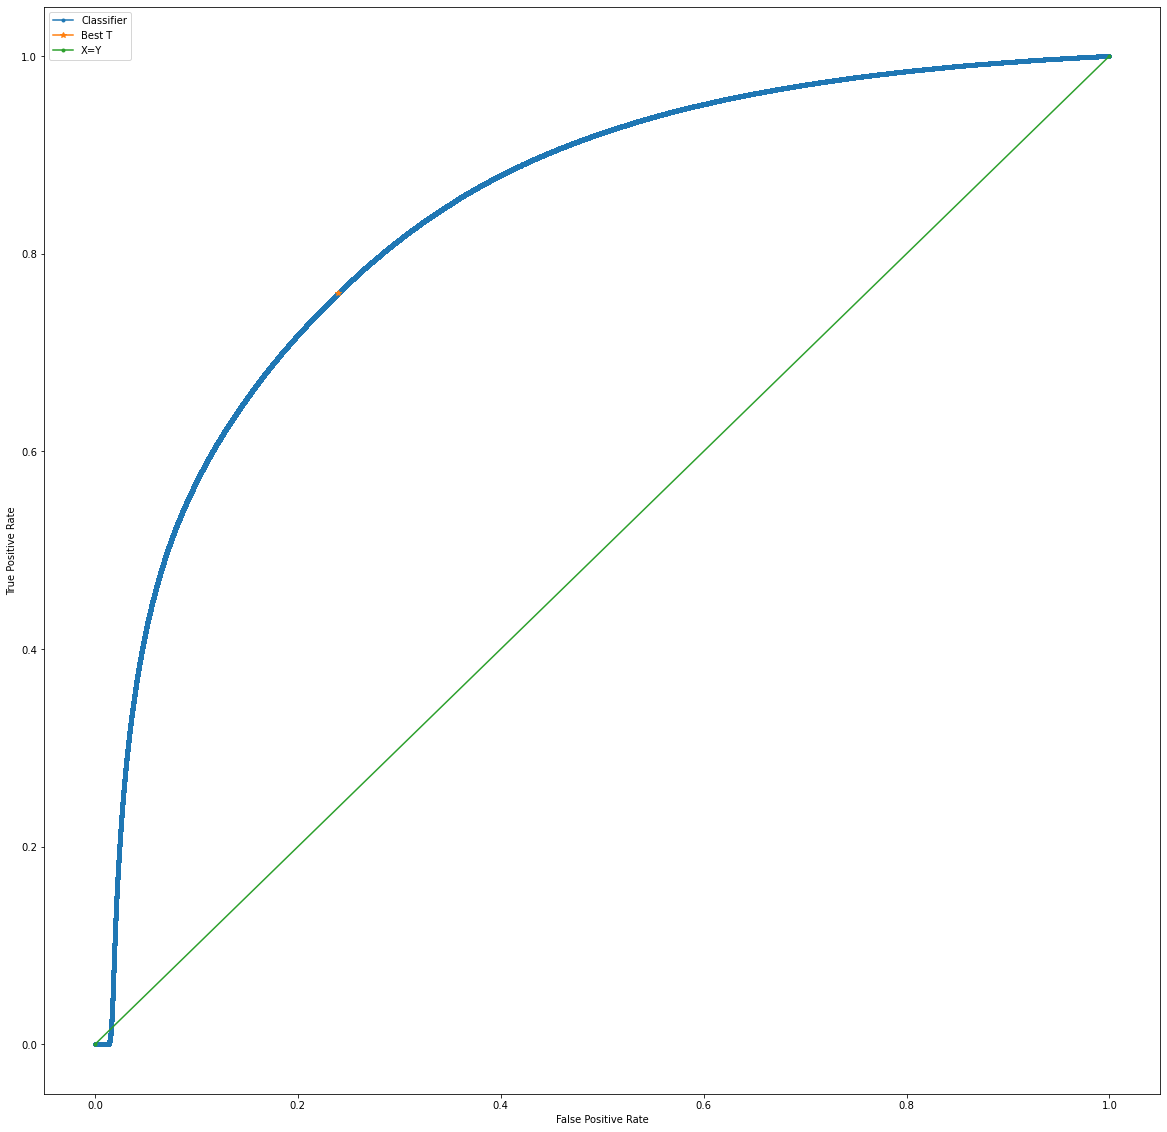

ndvi_q0.tiff
[2.         1.         0.99999493 ... 0.01472521 0.01467109 0.        ]
best T:  [0.28139907121658325]
ROC AUC:  0.8169441224178035


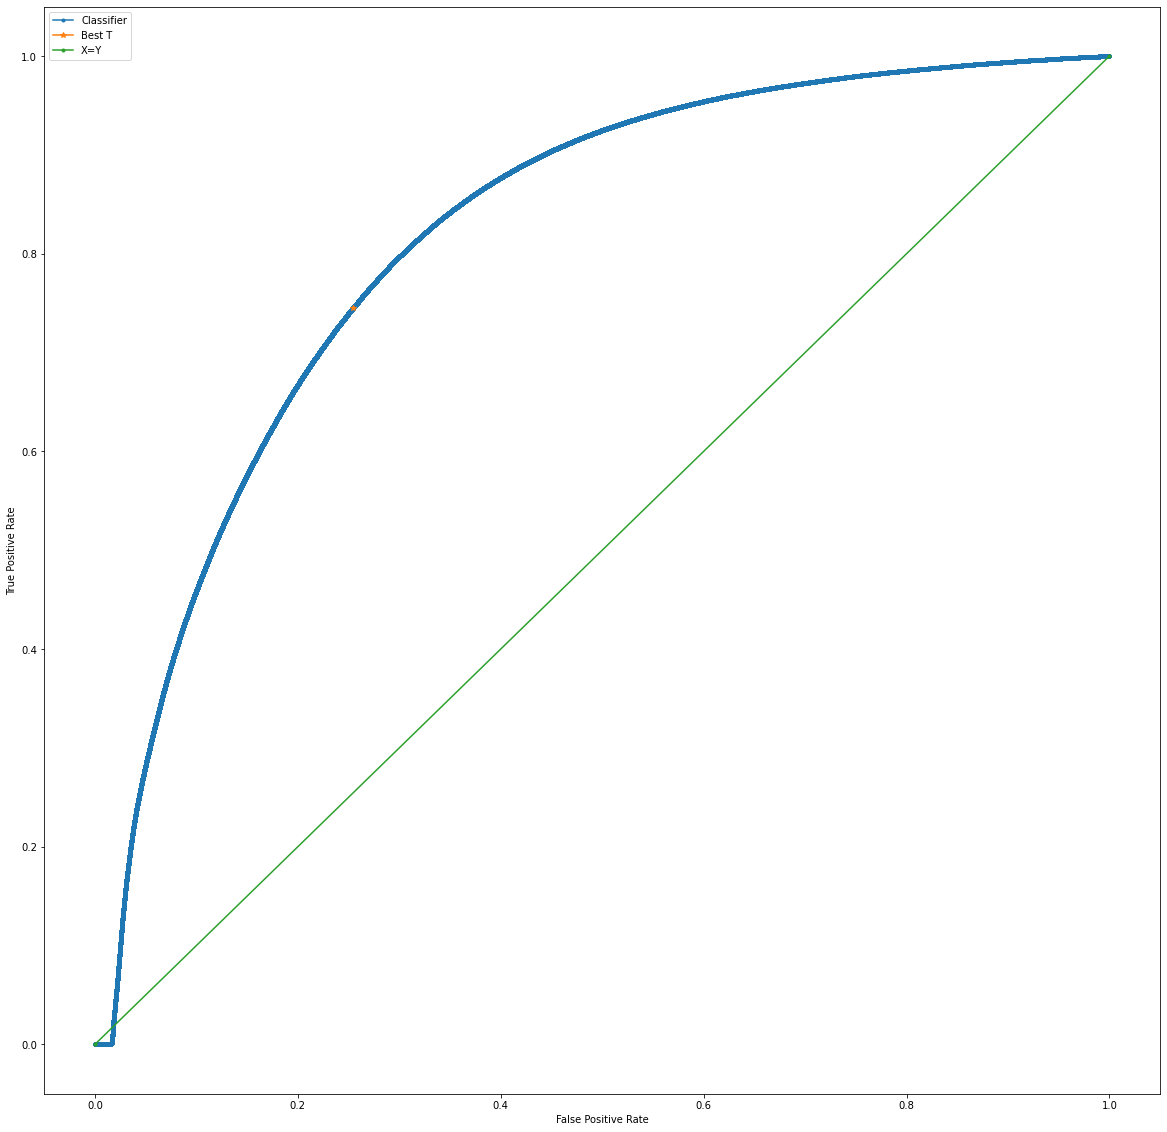

ndvi_q1.tiff
[2.         1.         0.9576952  ... 0.03077811 0.030774   0.        ]
best T:  [0.3942345380783081]
ROC AUC:  0.8267948914486609


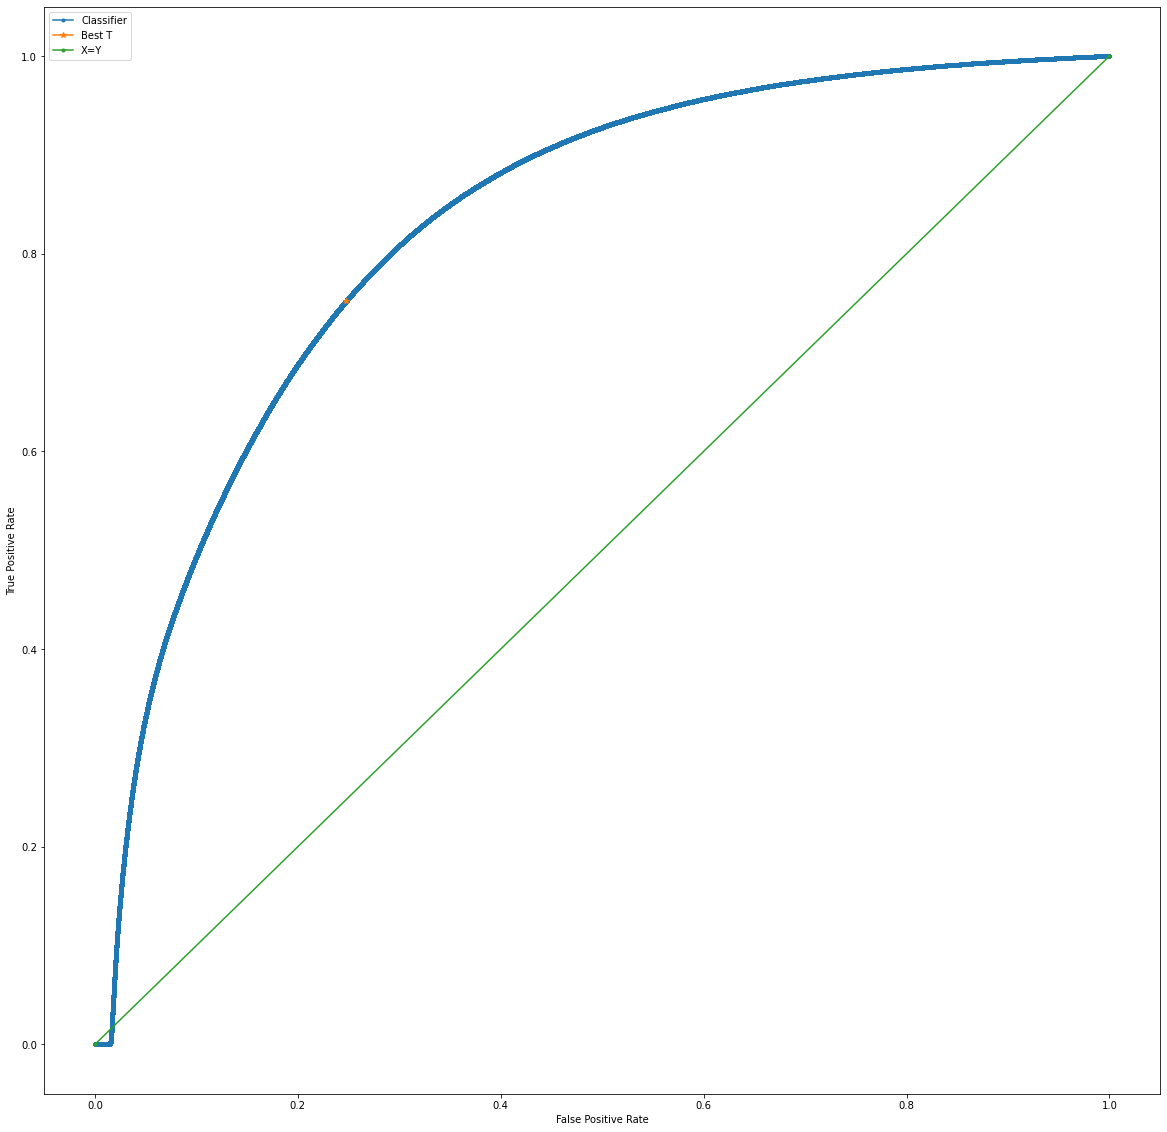

ndvi_q2.tiff
[2.         1.         0.97913307 ... 0.02132219 0.02129924 0.        ]
best T:  [0.39079660177230835]
ROC AUC:  0.8383975734051248


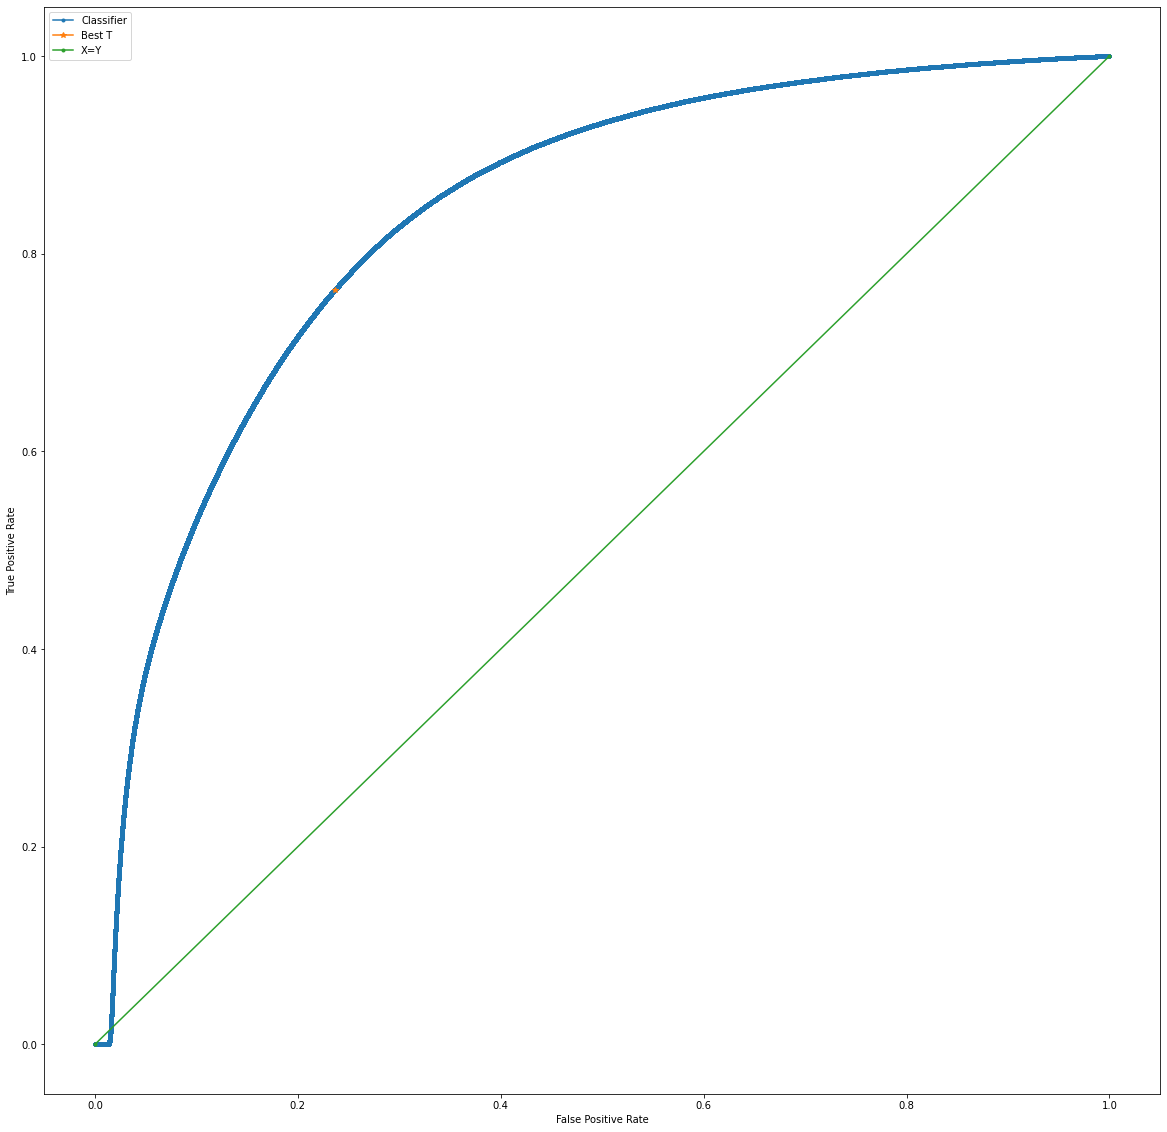

ndvi_q3.tiff
[2.         1.         0.97562295 ... 0.02742863 0.0274089  0.        ]
best T:  [0.3441447615623474]
ROC AUC:  0.8256071738599704


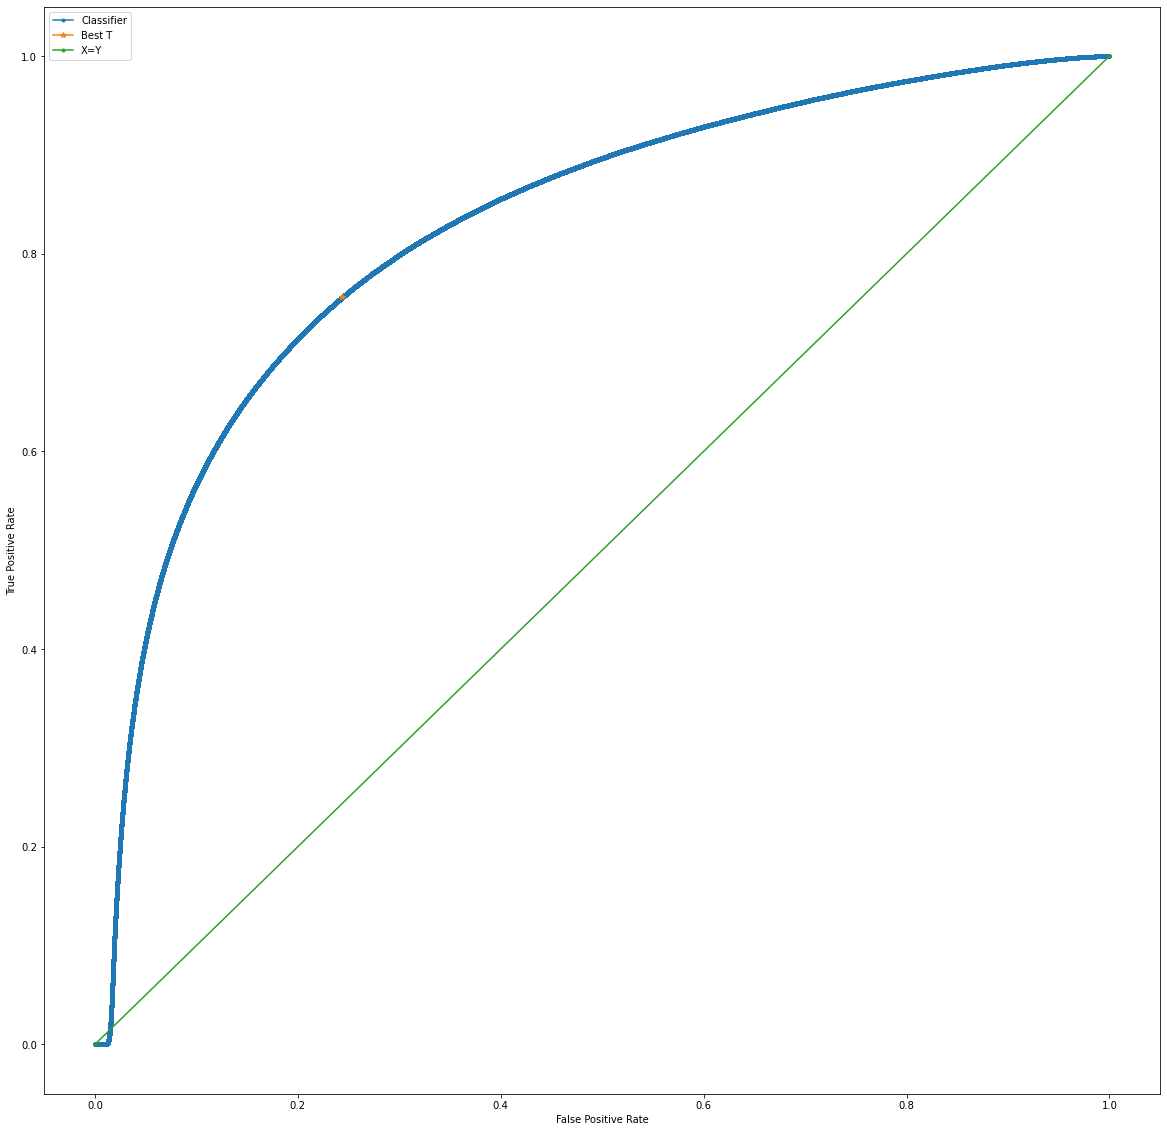

ndvi_q4.tiff
[2.0000000e+00 1.0000000e+00 9.8917043e-01 ... 5.3226948e-05 2.9742718e-05
 0.0000000e+00]
best T:  [0.37588703632354736]
ROC AUC:  0.7815318541466088


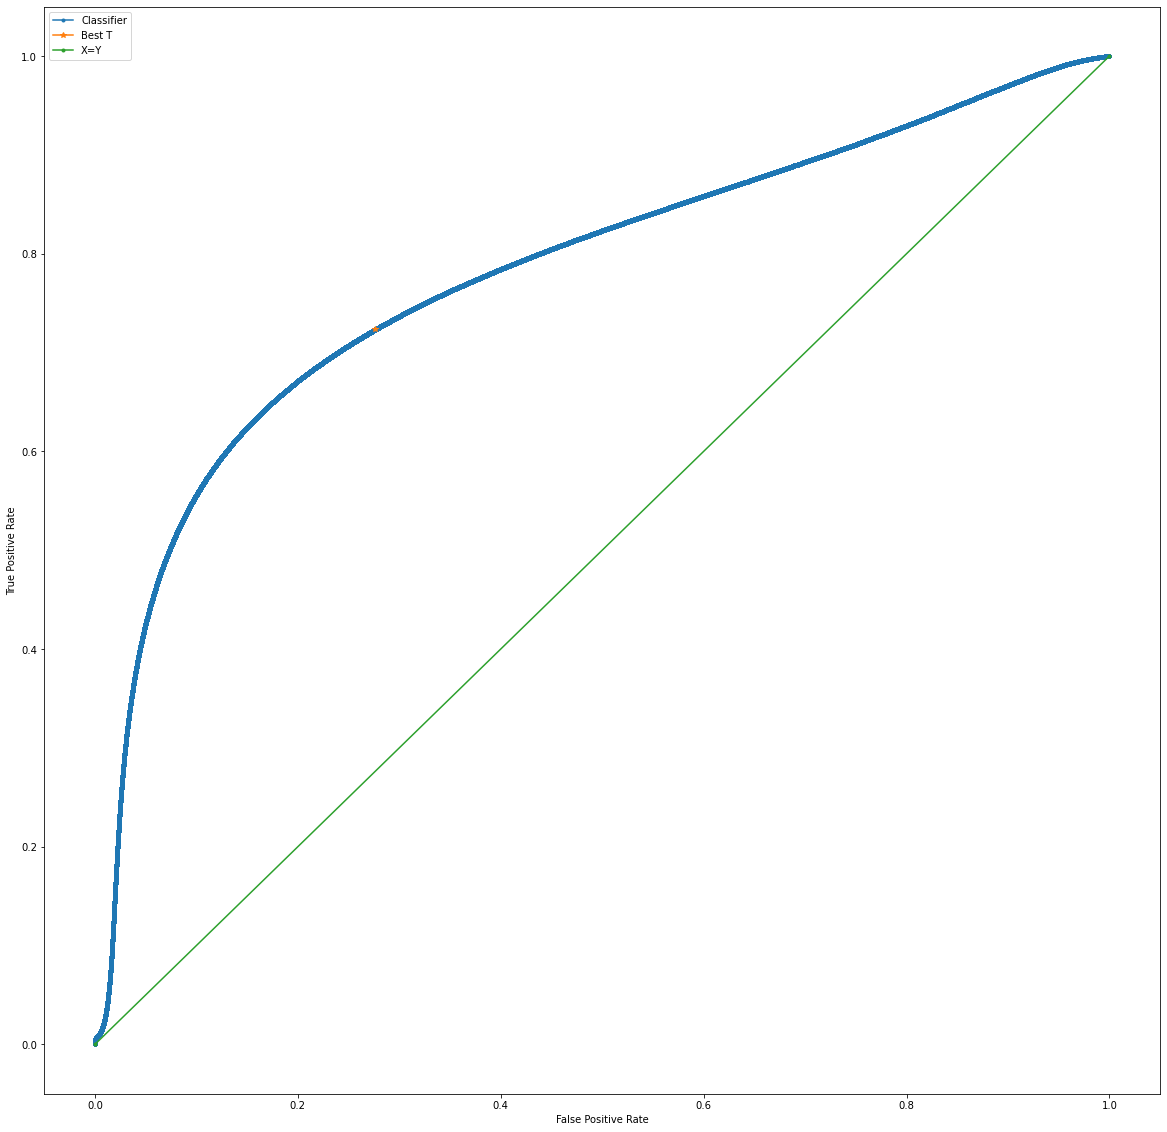

ndvi_var.tiff
[2.         1.         0.9980492  ... 0.06145519 0.06124842 0.        ]
best T:  [0.7211591601371765]
ROC AUC:  0.5730286551592184


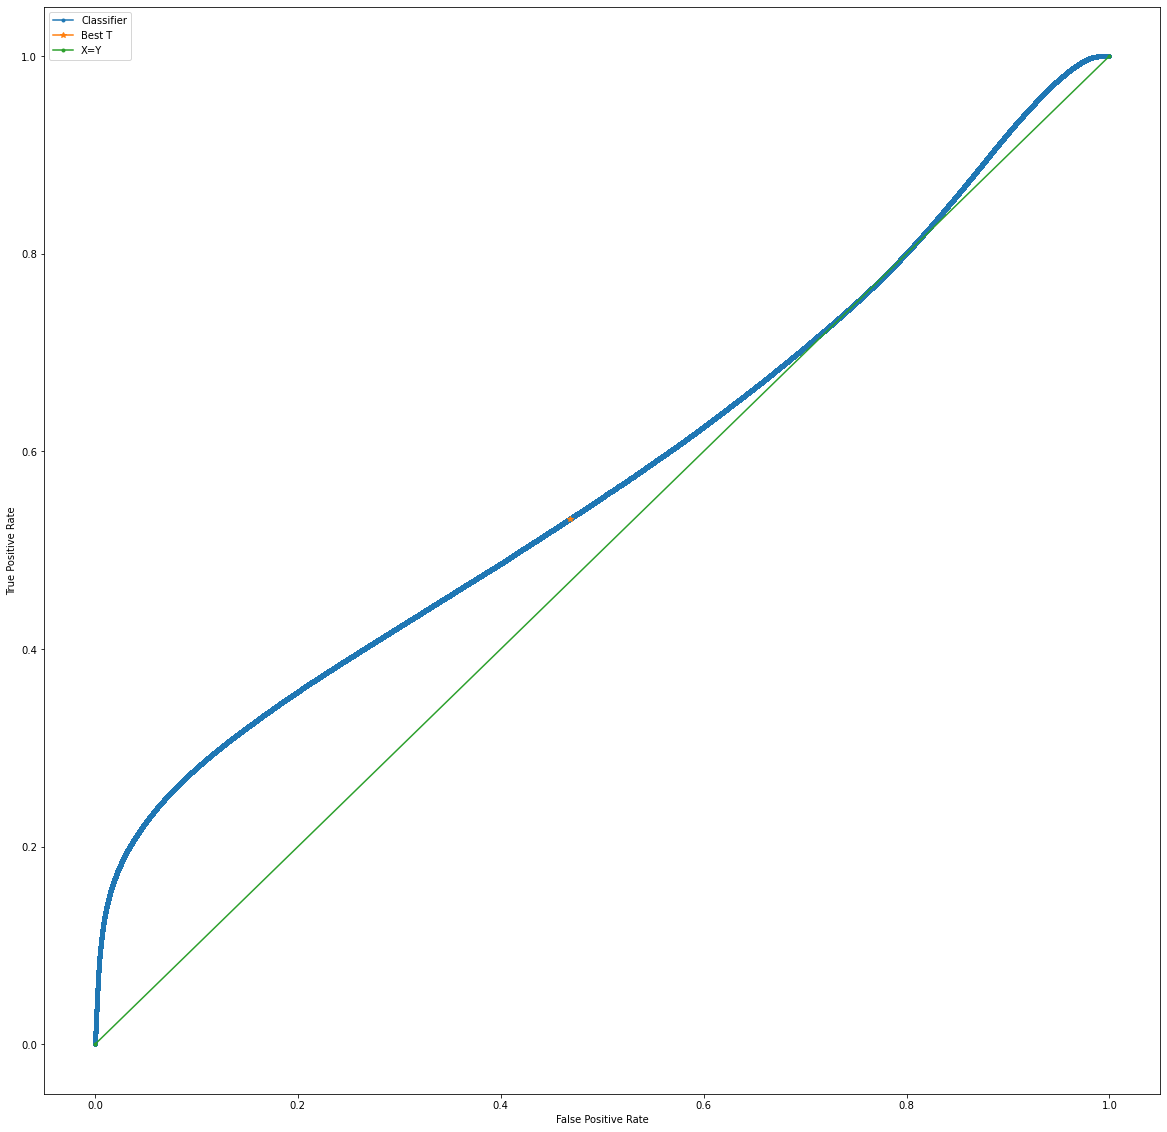

In [19]:
for f in src_dss:
    print(f)
    f_dst = '../sensing_data/clipped/vila-de-rei/ignored/' + f
    f = '../sensing_data/clipped/vila-de-rei/tstats/' + f
    
    
    test_ds = gdal.Open(f, gdal.GA_ReadOnly)
    test_ds = test_ds.GetRasterBand(1).ReadAsArray()    
    test_ds = (test_ds - np.min(test_ds))/(np.max(test_ds) - np.min(test_ds))
    test_ds = 1 - test_ds
    shape = test_ds.shape
    
    fpr, tpr, thresholds, roc_auc = compute_roc(test_ds_true.flatten(), test_ds.flatten())
    print(thresholds)
    opt_t = find_optimal_cutoff(test_ds_true.flatten(), test_ds.flatten())
    opt_t_idx = np.where(thresholds == opt_t)
    print('best T: ', opt_t)
    print('ROC AUC: ', roc_auc)
    plo_roc(fpr, tpr, opt_t_idx, roc_auc)
    
    test_ds = test_ds.flatten()

    test_ds[test_ds > opt_t] = 1
    test_ds[test_ds <= opt_t] = 0
    
    test_ds = test_ds.reshape(shape)
    viz.createGeotiff(f_dst, test_ds,
                      '../sensing_data/clipped/vila-de-rei/ignored/static/clipped_sentinel2_B08.vrt', gdal.GDT_Byte)

In [20]:
best_t = 0.36036157608032227
og_test_ds = gdal.Open('../sensing_data/clipped/vila-de-rei/tstats/ndvi_q4.tiff', gdal.GA_ReadOnly)
og_test_ds = og_test_ds.GetRasterBand(1).ReadAsArray()
test_ds_norm = (og_test_ds - np.min(og_test_ds))/(np.max(og_test_ds) - np.min(og_test_ds))
test_ds_inv = 1 - test_ds_norm
shape = test_ds_inv.shape

test_ds = test_ds_inv.flatten()

test_ds[test_ds > best_t] = 1
test_ds[test_ds <= best_t] = 0

Kappa: 0.09600813340975933
              precision    recall  f1-score   support

           0       0.98      0.67      0.79  18538114
           1       0.09      0.75      0.17    848511

    accuracy                           0.67  19386625
   macro avg       0.54      0.71      0.48  19386625
weighted avg       0.94      0.67      0.77  19386625

Roc Auc:  0.7099596552557184
Jaccard Score:  0.09076016493525836


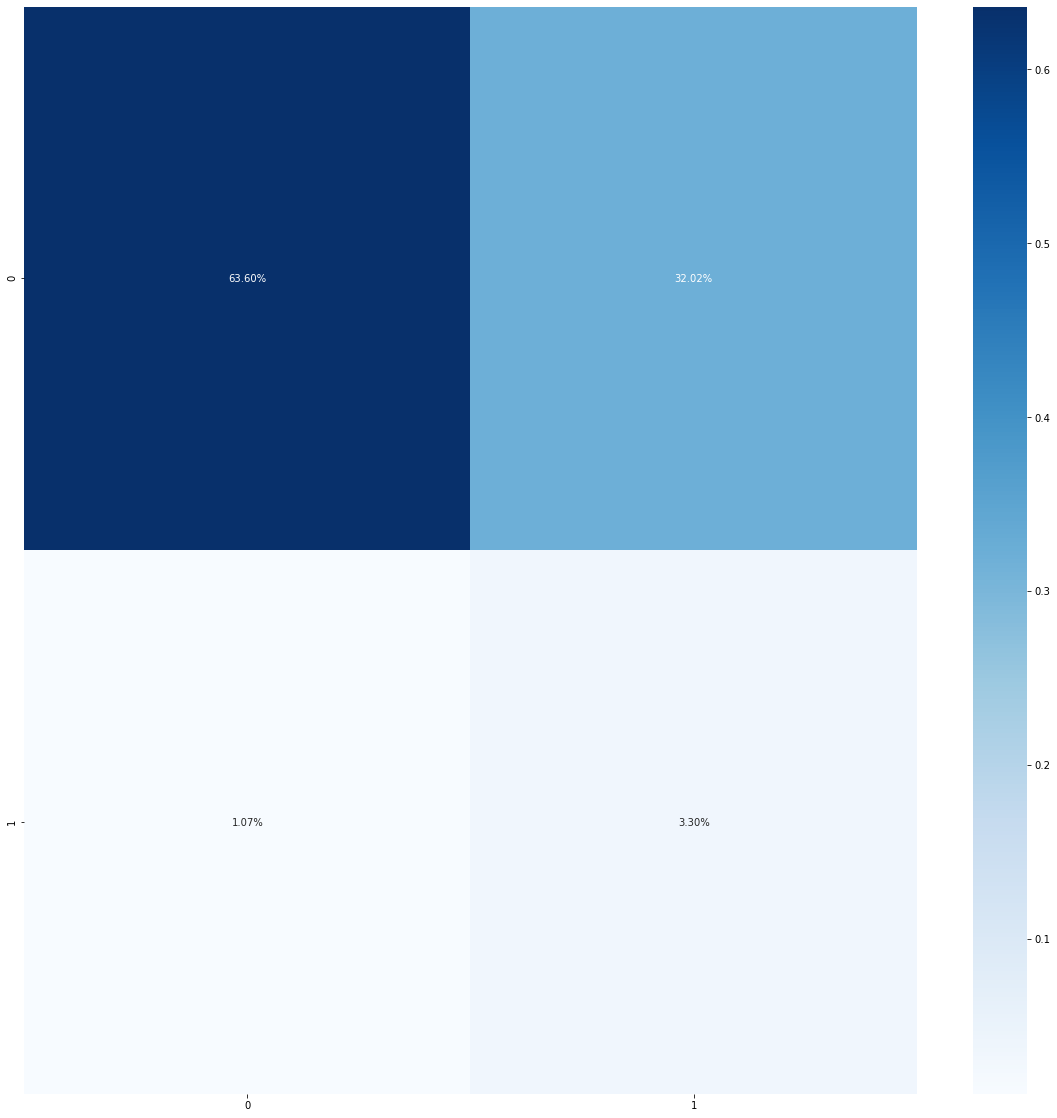

In [21]:
compare_metrics(test_ds_true.flatten(), test_ds)

In [24]:
test_ds = test_ds.reshape(shape)

In [51]:
viz.createGeotiff('../sensing_data/clipped/vila-de-rei/ignored/test.tiff', test_ds,
                      '../sensing_data/clipped/vila-de-rei/ignored/static/clipped_sentinel2_B08.vrt', gdal.GDT_Byte)

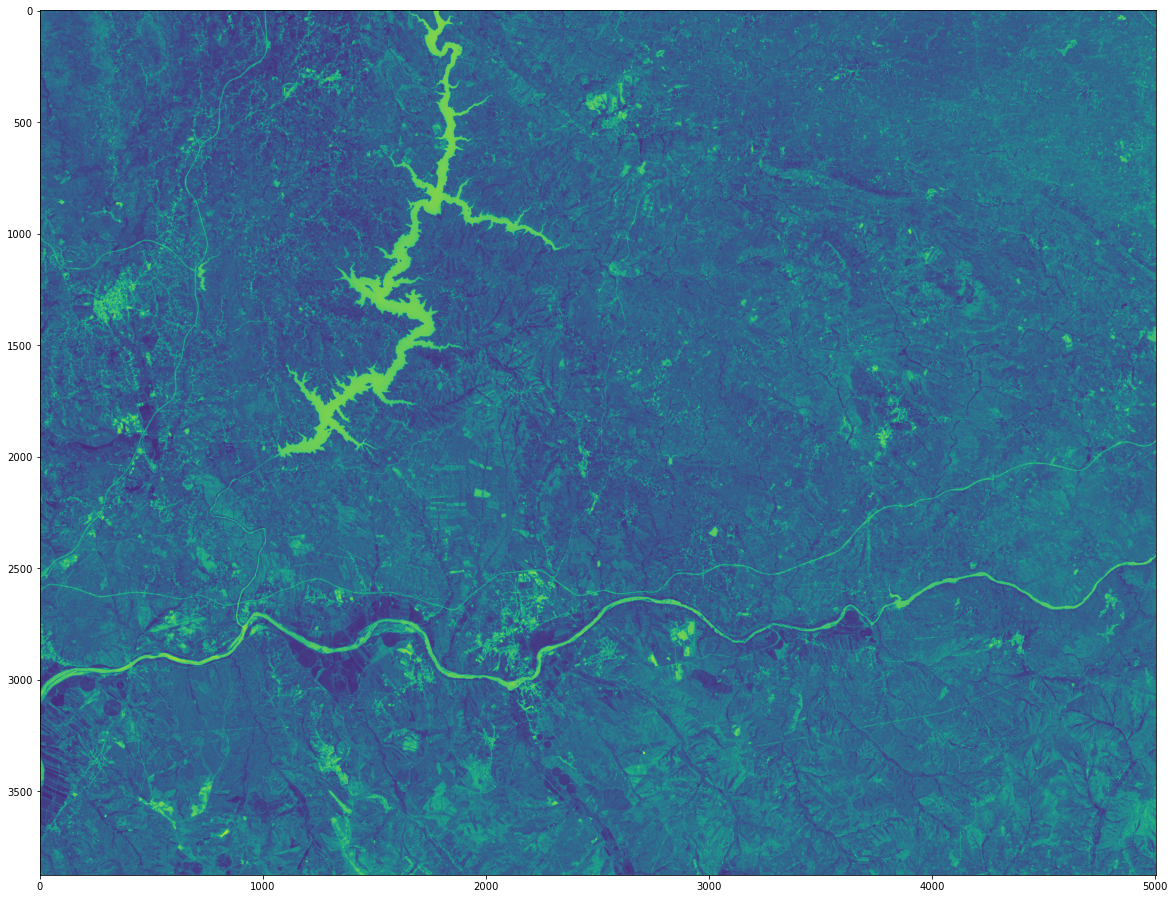

In [25]:
imgplot2 = plt.imshow(test_ds_inv)
plt.show()

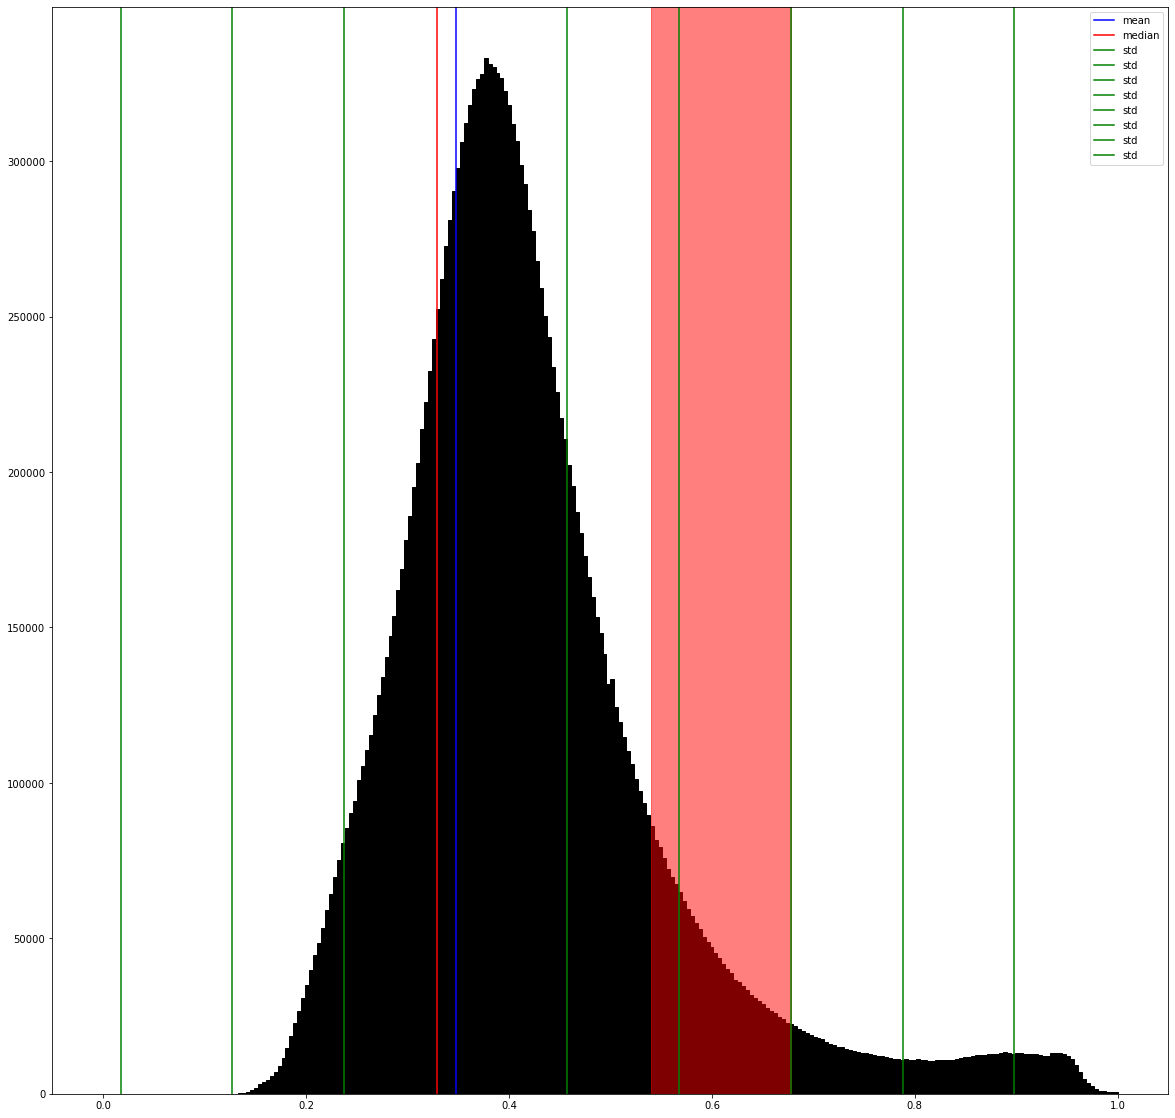

In [26]:
mean = np.mean(test_ds_inv)
std = np.std(test_ds_inv)
median = np.median(test_ds_inv)

low_cut = 1.75
high_cut = 3

ds_inv = 1 - og_test_ds

plt.hist(ds_inv.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')

plt.axvline(x=mean, label='mean', c='b')
plt.axvline(x=median, label='median',c='r')

plt.axvline(x=mean+std, label='std',c='g')
plt.axvline(x=mean-std, label='std',c='g')

plt.axvline(x=mean+2*std, label='std',c='g')
plt.axvline(x=mean+3*std, label='std',c='g')
plt.axvline(x=mean+4*std, label='std',c='g')
plt.axvline(x=mean+5*std, label='std',c='g')

plt.axvline(x=mean-2*std, label='std',c='g')
plt.axvline(x=mean-3*std, label='std',c='g')

plt.axvspan(mean+low_cut*std, mean+high_cut*std, alpha=0.5, color='red')

plt.legend()
plt.show()

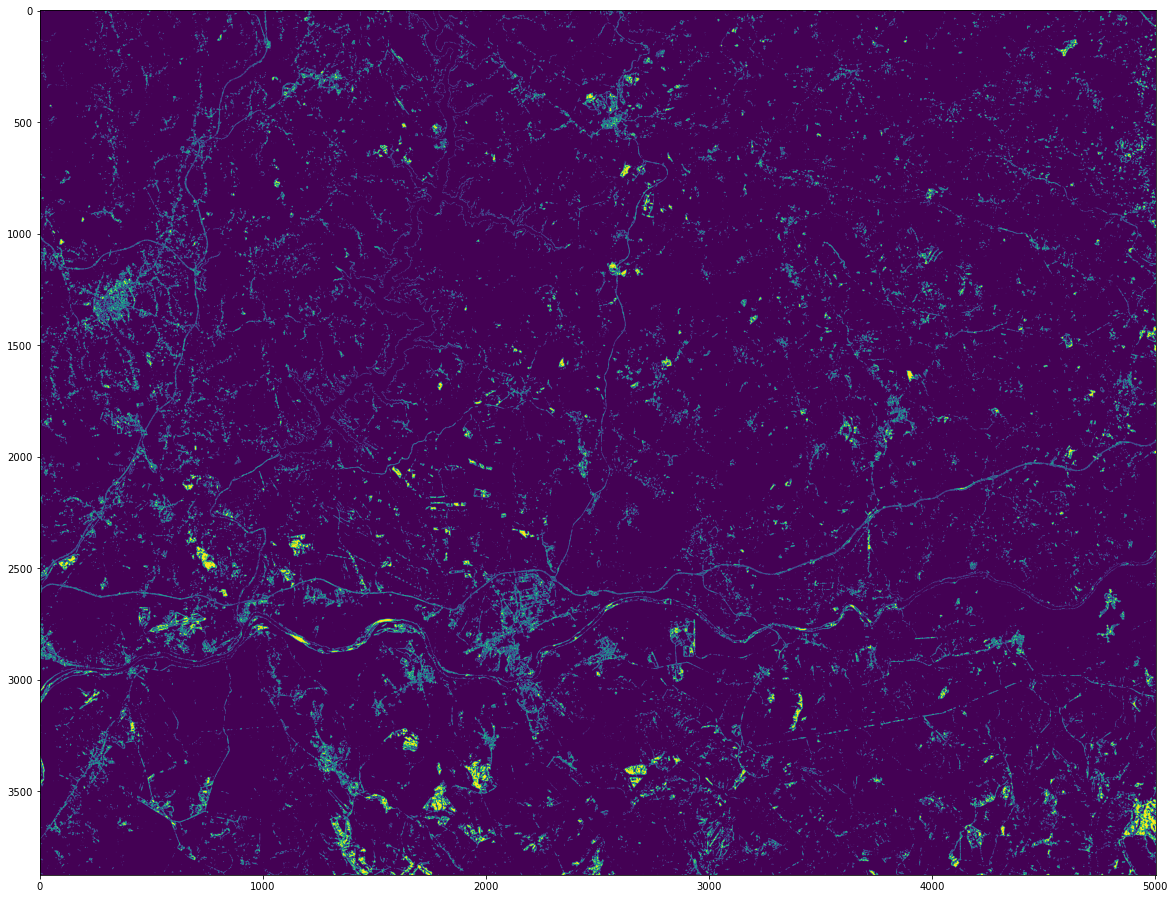

In [27]:
temp_hist = np.copy(test_ds_inv)

temp_hist[temp_hist > mean+high_cut*std] = 0

temp_hist[temp_hist <= mean+low_cut*std] = 0
temp_hist[temp_hist > mean+low_cut*std] = 1

imgplot = plt.imshow(temp_hist)
plt.show()

In [106]:
viz.createGeotiff('../sensing_data/clipped/vila-de-rei/ignored/thold_test.tiff', temp_hist,
                      '../sensing_data/clipped/vila-de-rei/ignored/static/clipped_sentinel2_B08.vrt', gdal.GDT_Byte)

In [27]:
og_test_ds = gdal.Open('../sensing_data/clipped/vila-de-rei/t1stats/VV_q4.tiff', gdal.GA_ReadOnly)
og_test_ds = og_test_ds.GetRasterBand(1).ReadAsArray()
test_ds_norm_vv = (og_test_ds - np.min(og_test_ds))/(np.max(og_test_ds) - np.min(og_test_ds))

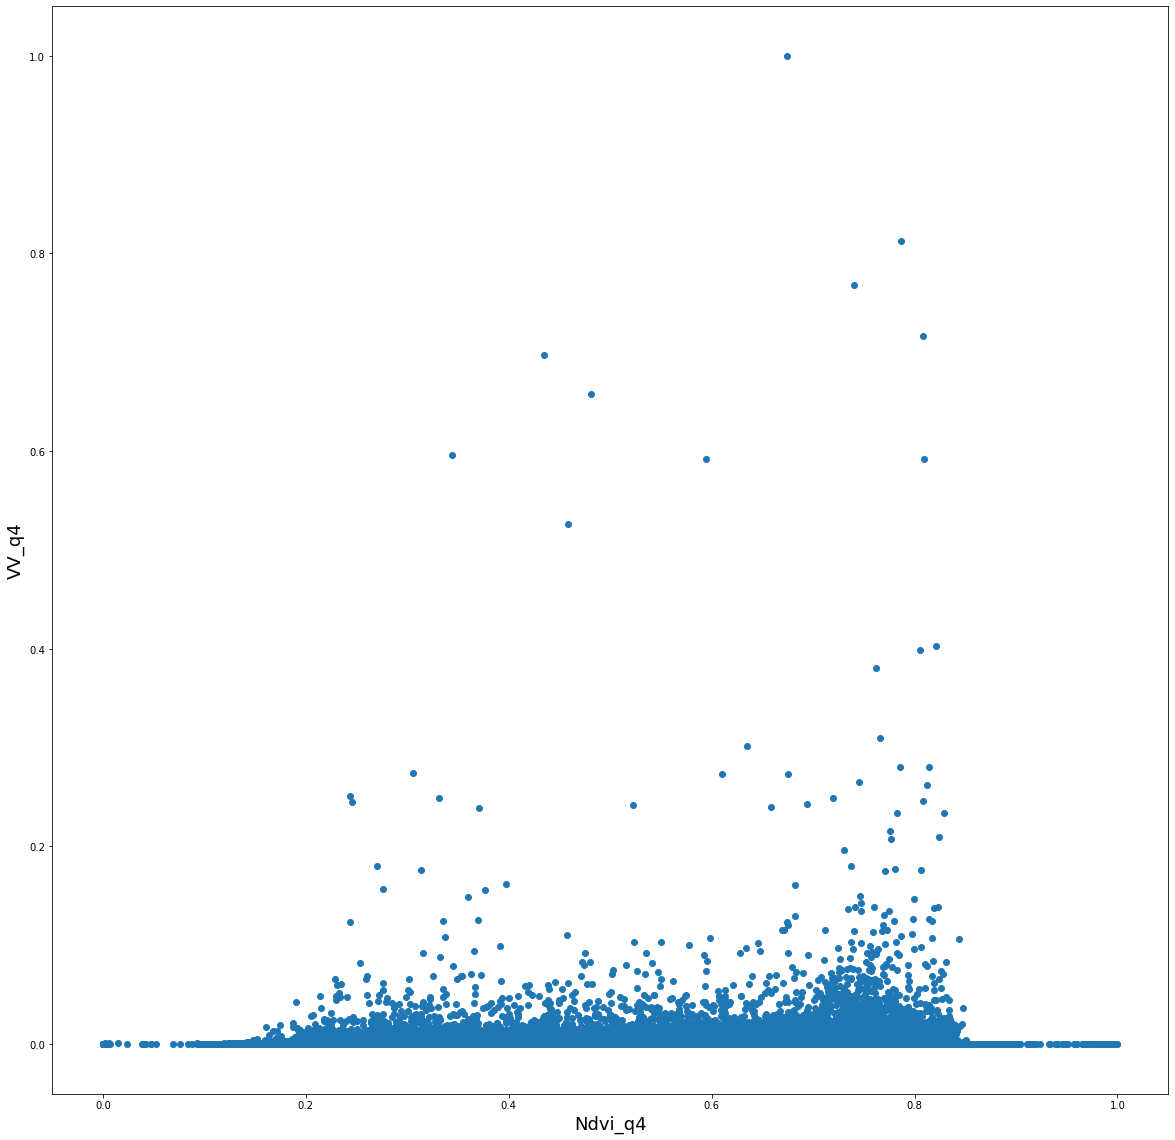

In [31]:
plt.scatter(test_ds_inv ,test_ds_norm_vv)
plt.xlabel('Ndvi_q4', fontsize=18)
plt.ylabel('VV_q4', fontsize=18)
plt.show()